# Detecção multi-escala MNIST (v.2)

## Importando módulos

In [1]:
import os
import pkgutil

if pkgutil.find_loader('torch') is None:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device:", device)

Device: cuda


## Dataset

In [4]:
dataset_dir = '../data/MNIST/processed/'
num_scales = 2

In [5]:
class MultiScaleMNIST(torch.utils.data.Dataset):
    def __init__(self, processed_data_dir, length, mat_size=320, num_cells=20, num_scales=2, debug=False):
        num_attempts = 20
        base_cell_size = mat_size / num_cells

        self.length = length
        self.num_scales = num_scales

        test_data, test_label = torch.load(os.path.join(processed_data_dir, 'test.pt'))
        train_data, train_label = torch.load(os.path.join(processed_data_dir, 'training.pt'))

        self.joint_data = torch.cat((train_data, test_data), dim=0).type(torch.FloatTensor) / 255.0
        self.joint_label = torch.cat((train_label, test_label), dim=0)

        self.data_shift_v = torch.empty(self.joint_data.shape)
        self.data_shift_h = torch.empty(self.joint_data.shape)
        self.data_shift_d = torch.empty(self.joint_data.shape)

        self.data_shift_v[:, :-1, :] = self.joint_data[:, 1:, :] - self.joint_data[:, :-1, :]
        self.data_shift_h[:, :, :-1] = self.joint_data[:, :, 1:] - self.joint_data[:, :, :-1]
        self.data_shift_d[:, :-1, :-1] = self.joint_data[:, 1:, 1:] - self.joint_data[:, :-1, :-1]

        self.data_shift_v[:, -1, :] = self.joint_data[:, -1, :]
        self.data_shift_h[:, :, -1] = self.joint_data[:, :, -1]
        self.data_shift_d[:, -1, :] = self.joint_data[:, -1, :]
        self.data_shift_d[:, :, -1] = self.joint_data[:, :, -1]

        data_idx_array = np.arange(self.joint_data.shape[0])

        self.mat_image = torch.zeros((self.length, 1, mat_size, mat_size), dtype=torch.float)
        self.mat_label_reg = dict()
        self.mat_label_cls = dict()

        digit_size = dict()
        cell_size = dict()
        cell_central_pixel = dict()
        cell_pixel_between = dict()

        for scale in range(self.num_scales, 0, -1):
            digit_size[scale] = 28 * scale
            num_cells_scale = num_cells // scale
            cell_size[scale] = base_cell_size * scale

            cell_central_pixel[scale] = np.arange(cell_size[scale]/2, mat_size, cell_size[scale])
            cell_pixel_between[scale] = (cell_central_pixel[scale][:-1] + cell_central_pixel[scale][1:]) // 2

            self.mat_label_reg[scale] = torch.zeros((self.length, 2, num_cells_scale, num_cells_scale), dtype=torch.float)
            self.mat_label_cls[scale] = torch.zeros((self.length, 2, num_cells_scale, num_cells_scale), dtype=torch.long)
            self.mat_label_cls[scale][:, 0] = -1

        for sample_idx in range(self.length):
            frame_list = list()

            for scale in range(self.num_scales, 0, -1):
                np.random.shuffle(data_idx_array)
                num_digits = np.random.randint(10, 20)
                digit_idx_array = data_idx_array[:num_digits]

                for digit_idx in digit_idx_array:
                    digit_attempt = 0

                    while digit_attempt != num_attempts:
                        x1, y1 = np.random.randint(0, mat_size-digit_size[scale], size=2)
                        x2, y2 = x1+digit_size[scale], y1+digit_size[scale]

                        frame_idx = 0
                        while frame_idx != len(frame_list):
                            frame_entry = frame_list[frame_idx]

                            x1_between = (x1 >= frame_entry[0]) and (x1 < frame_entry[2])
                            x2_between = (x2 >= frame_entry[0]) and (x2 < frame_entry[2])
                            x_between = x1_between or x2_between

                            y1_between = (y1 >= frame_entry[1]) and (y1 < frame_entry[3])
                            y2_between = (y2 >= frame_entry[1]) and (y2 < frame_entry[3])
                            y_between = y1_between or y2_between

                            if x_between and y_between:
                                break
                            else:
                                frame_idx += 1

                        if frame_idx == len(frame_list):
                            frame_list.append([x1, y1, x2, y2])
                            break
                        else:
                            digit_attempt += 1

                    if digit_attempt != num_attempts:
                        frame = frame_list[-1]
                        self.mat_image[sample_idx, 0,
                                       frame[1]:frame[3],
                                       frame[0]:frame[2]] = self.resize_digit(digit_idx, scale)

                        # Compute distance of digit centroid to each cell interface to pick the right cell and tx/ty
                        x_centroid = frame[0] + (digit_size[scale] // 2)
                        y_centroid = frame[1] + (digit_size[scale] // 2)

                        x_centroid_diff = cell_pixel_between[scale] - x_centroid
                        y_centroid_diff = cell_pixel_between[scale] - y_centroid

                        x_closest_pixel = np.argmin(np.abs(x_centroid_diff))
                        y_closest_pixel = np.argmin(np.abs(y_centroid_diff))

                        x_central_pixel_idx = x_closest_pixel if x_centroid_diff[x_closest_pixel] >= 0 else x_closest_pixel + 1
                        y_central_pixel_idx = y_closest_pixel if y_centroid_diff[y_closest_pixel] >= 0 else y_closest_pixel + 1

                        x_central_pixel = cell_central_pixel[scale][x_central_pixel_idx]
                        y_central_pixel = cell_central_pixel[scale][y_central_pixel_idx]

                        tx = cell_pixel_between[scale][x_closest_pixel] - x_centroid_diff[x_closest_pixel] - x_central_pixel
                        ty = cell_pixel_between[scale][y_closest_pixel] - y_centroid_diff[y_closest_pixel] - y_central_pixel

                        self.mat_label_reg[scale][sample_idx, 0, y_central_pixel_idx, x_central_pixel_idx] = tx
                        self.mat_label_reg[scale][sample_idx, 1, y_central_pixel_idx, x_central_pixel_idx] = ty
                        self.mat_label_cls[scale][sample_idx, 0, y_central_pixel_idx, x_central_pixel_idx] = self.joint_label[digit_idx]
                        self.mat_label_cls[scale][sample_idx, 1, y_central_pixel_idx, x_central_pixel_idx] = 1

                        if debug:
                            print(f'Digit {self.joint_label[digit_idx]}: coord {frame}')

        if not debug:
            for scale in self.mat_label_reg:
                self.mat_label_reg[scale] /= (cell_size[scale] / 2)

    def resize_digit(self, digit_idx, scale):
        digit = self.joint_data[digit_idx]
        digit_shape = digit.shape

        scaled_digit = torch.empty((digit_shape[0] * scale, digit_shape[1] * scale))

        digit_shift_v = self.data_shift_v[digit_idx] / scale
        digit_shift_h = self.data_shift_h[digit_idx] / scale
        digit_shift_d = self.data_shift_d[digit_idx] / scale

        for v_idx in range(scale):
            for h_idx in range(scale):
                if v_idx == h_idx:
                    weighted_digit_shift = digit_shift_d * v_idx
                elif v_idx > h_idx:
                    weighted_digit_shift_v = digit_shift_v * v_idx
                    weighted_digit_shift_h = digit_shift_d * h_idx
                    weighted_digit_shift = ((weighted_digit_shift_v * v_idx) + (weighted_digit_shift_h * h_idx)) / (v_idx + h_idx)
                else:
                    weighted_digit_shift_v = digit_shift_d * v_idx
                    weighted_digit_shift_h = digit_shift_h * h_idx
                    weighted_digit_shift = ((weighted_digit_shift_v * v_idx) + (weighted_digit_shift_h * h_idx)) / (v_idx + h_idx)

                scaled_digit[v_idx::scale, h_idx::scale] = digit + weighted_digit_shift

        return scaled_digit

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        label_reg = list()
        label_cls = list()

        for scale in range(self.num_scales, 0, -1):
            label_reg.append(self.mat_label_reg[scale][index])
            label_cls.append(self.mat_label_cls[scale][index])

        return self.mat_image[index], label_reg, label_cls

### Visualização de exemplo

In [6]:
def vizSample(dataset, idx):
    image, label_reg_list, label_cls_list = dataset[idx]

    plt.imshow(image[0].numpy())
    plt.show()

    num_scales = len(label_reg_list)
    for scale_idx in range(num_scales):
        scale_label = num_scales - scale_idx
        print(f'\nScale {scale_label}')
        print(f'tx:\n{label_reg_list[scale_idx][0]}\n')
        print(f'ty:\n{label_reg_list[scale_idx][1]}\n')
        print(f'class:\n{label_cls_list[scale_idx][0]}\n')
        print(f'presence:\n{label_cls_list[scale_idx][1]}\n')

In [7]:
mnist_dataset = MultiScaleMNIST(dataset_dir, 1, num_scales=num_scales, debug=True)

Digit 8: coord [166, 155, 222, 211]
Digit 7: coord [79, 192, 135, 248]
Digit 4: coord [216, 237, 272, 293]
Digit 1: coord [85, 10, 141, 66]
Digit 9: coord [44, 71, 100, 127]
Digit 1: coord [234, 31, 290, 87]
Digit 5: coord [259, 143, 315, 199]
Digit 0: coord [18, 220, 74, 276]
Digit 9: coord [159, 69, 215, 125]
Digit 8: coord [6, 129, 62, 185]
Digit 0: coord [79, 259, 135, 315]
Digit 6: coord [143, 219, 199, 275]
Digit 6: coord [105, 75, 133, 103]
Digit 2: coord [37, 12, 65, 40]
Digit 2: coord [115, 123, 143, 151]
Digit 5: coord [188, 30, 216, 58]
Digit 3: coord [114, 163, 142, 191]
Digit 9: coord [4, 2, 32, 30]
Digit 8: coord [287, 242, 315, 270]
Digit 2: coord [138, 284, 166, 312]
Digit 5: coord [268, 95, 296, 123]
Digit 9: coord [169, 276, 197, 304]
Digit 8: coord [224, 133, 252, 161]
Digit 9: coord [144, 37, 172, 65]
Digit 4: coord [8, 47, 36, 75]
Digit 4: coord [4, 86, 32, 114]
Digit 6: coord [20, 284, 48, 312]


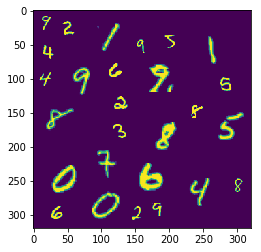


Scale 2
tx:
tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   0.,   0.,   0.,   0., -10.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  -8.,   0.,   0.,  11.,   0.,   0.,   0.,   0.],
        [  0., -14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0., -14.,   0.,  15.,   0.],
        [  0.,   0.,   0.,  -5.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  -2.,   0.,   0.,   0.,  -5.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  -5.,   0.,   0.,   0.,   4.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

ty:
tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., -10.,   0.,   0.,   0.,   0.,  11.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., -13.,   0.,   0., -15.,   0.,   0.,   0.,   0.],
 

In [8]:
vizSample(mnist_dataset, 0)

### Criação dos datasets de Treinamento, Validação e Teste

In [9]:
num_samples_train = 4000
num_samples_valid = 800
num_samples_test = 200

dataset_train = MultiScaleMNIST(dataset_dir, num_samples_train, num_scales=num_scales)
dataset_valid = MultiScaleMNIST(dataset_dir, num_samples_valid, num_scales=num_scales)
dataset_test = MultiScaleMNIST(dataset_dir, num_samples_test, num_scales=num_scales)

## Dataloaders

In [10]:
batch_size = 8

dataloaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)
}

## Modelo de Rede Neural

In [11]:
class MultiScaleModel(torch.nn.Module):
    def __init__(self):
        super(MultiScaleModel, self).__init__()

        self.act_func = torch.nn.LeakyReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

        self.conv01 = torch.nn.Conv2d(in_channels=1, out_channels=40, kernel_size=3, padding=1)
        self.conv02 = torch.nn.Conv2d(in_channels=40, out_channels=38, kernel_size=3, padding=1)
        self.conv03 = torch.nn.Conv2d(in_channels=38, out_channels=36, kernel_size=3, padding=1)
        self.conv04 = torch.nn.Conv2d(in_channels=36, out_channels=34, kernel_size=3, padding=1)
        self.conv05 = torch.nn.Conv2d(in_channels=34, out_channels=32, kernel_size=3, padding=1)
        self.conv06 = torch.nn.Conv2d(in_channels=32, out_channels=30, kernel_size=3, padding=1)
        self.conv07 = torch.nn.Conv2d(in_channels=30, out_channels=28, kernel_size=3, padding=1)
        self.conv08 = torch.nn.Conv2d(in_channels=28, out_channels=26, kernel_size=3, padding=1)
        self.conv09 = torch.nn.Conv2d(in_channels=26, out_channels=24, kernel_size=3, padding=1)
        self.conv10 = torch.nn.Conv2d(in_channels=24, out_channels=22, kernel_size=3, padding=1)
        self.conv11 = torch.nn.Conv2d(in_channels=22, out_channels=20, kernel_size=3, padding=1)
        self.conv12 = torch.nn.Conv2d(in_channels=20, out_channels=18, kernel_size=3, padding=1)
        self.conv13 = torch.nn.Conv2d(in_channels=18, out_channels=16, kernel_size=3, padding=1)
        self.conv14 = torch.nn.Conv2d(in_channels=16, out_channels=14, kernel_size=3, padding=1)
        self.conv15 = torch.nn.Conv2d(in_channels=14, out_channels=14, kernel_size=3, padding=1)
        self.conv16 = torch.nn.Conv2d(in_channels=14, out_channels=14, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv01(x)    #  40 x 320 x 320
        x = self.act_func(x)
        x = self.conv02(x)    #  38 x 320 x 320
        x = self.act_func(x)
        x = self.conv03(x)    #  36 x 320 x 320
        x = self.act_func(x)
        x = self.maxpool(x)   #  36 x 160 x 160

        x = self.conv04(x)    #  34 x 160 x 160
        x = self.act_func(x)
        x = self.conv05(x)    #  32 x 160 x 160
        x = self.act_func(x)
        x = self.conv06(x)    #  30 x 160 x 160
        x = self.act_func(x)
        x = self.maxpool(x)   #  30 x  80 x  80

        x = self.conv07(x)    #  28 x  80 x  80
        x = self.act_func(x)
        x = self.conv08(x)    #  26 x  80 x  80
        x = self.act_func(x)
        x = self.conv09(x)    #  24 x  80 x  80
        x = self.act_func(x)
        x = self.maxpool(x)   #  24 x  40 x  40

        x = self.conv10(x)    #  22 x  40 x  40
        x = self.act_func(x)
        x = self.conv11(x)    #  20 x  40 x  40
        x = self.act_func(x)
        x = self.conv12(x)    #  18 x  40 x  40
        x = self.act_func(x)
        x = self.maxpool(x)   #  18 x  20 x  20

        x = self.conv13(x)    #  16 x  20 x  20
        x = self.act_func(x)
        x = self.conv14(x)    #  14 x  20 x  20
        x = self.act_func(x)
        y = self.maxpool(x)   #  14 x  10 x  10

        y = self.conv15(y)    #  14 x  10 x  10
        y = self.act_func(y)
        y = self.conv16(y)    #  14 x  10 x  10
        y = self.act_func(y)

        return [y, x]

## Função de perda customizada

In [12]:
class MultiScaleLoss(torch.nn.Module):
    def __init__(self, num_scales=2):
        super().__init__()
        self.num_scales = num_scales

        presence_weights = torch.tensor([0.1, 1]).to(device)
        self.cel_presence = torch.nn.CrossEntropyLoss(weight=presence_weights)
        self.cel_class = torch.nn.CrossEntropyLoss(ignore_index=-1)

    def customMSELoss(self, predict, target, mask):
        num_elem = torch.sum(mask, (3, 2, 1))
        mse_loss_calc_1 = (predict - target) ** 2
        mse_loss_calc_2 = torch.sum(mse_loss_calc_1 * mask, (3, 2, 1)) / num_elem
        return torch.sum(mse_loss_calc_2) / len(mse_loss_calc_2)

    def forward(self, predict_list, target_reg_list, target_cls_list):
        # predict: M, 14, 10, 10
        loss_presence = list()
        loss_class = list()
        loss_t = list()

        for scale_idx in range(self.num_scales):
            predict_scale = predict_list[scale_idx].to(device)
            target_reg_scale = target_reg_list[scale_idx].to(device)
            target_cls_scale = target_cls_list[scale_idx].to(device)

            loss_presence.append(self.cel_presence(predict_scale[:, 12:], target_cls_scale[:, 1]))
            loss_class.append(self.cel_class(predict_scale[:, 2:12], target_cls_scale[:, 0]))
            loss_t.append(self.customMSELoss(predict_scale[:, :2], target_reg_scale,
                                             target_cls_scale[:, 1:].type(torch.float)))

        return sum(loss_presence + loss_class + loss_t)

## Teste das etapas (dataloader, modelo e função de perda)

In [13]:
label_entries = ['tx', 'ty', 'class', 'presence']

dataiter = iter(dataloaders['train'])
sample_images, sample_labels_reg_list, sample_labels_cls_list = dataiter.next()

print(f'Entrada')
print(f'    Formato: {sample_images.shape}')
print(f'    Tipo: {sample_images.dtype}')
print(f'    Faixa de valores: [{sample_images.min()}, {sample_images.max()}]')
print('\n')

print(f'Label')
for scale_idx in range(num_scales):
    print(f'    Scale {num_scales - scale_idx}')
    print(f'        tx')
    print(f'            Formato: {sample_labels_reg_list[scale_idx].shape}')
    print(f'            Tipo: {sample_labels_reg_list[scale_idx].dtype}')
    print(f'            Faixa de valores: [{sample_labels_reg_list[scale_idx][:, 0].min()}, {sample_labels_reg_list[scale_idx][:, 0].max()}]')
    print(f'        ty')
    print(f'            Formato: {sample_labels_reg_list[scale_idx].shape}')
    print(f'            Tipo: {sample_labels_reg_list[scale_idx].dtype}')
    print(f'            Faixa de valores: [{sample_labels_reg_list[scale_idx][:, 1].min()}, {sample_labels_reg_list[scale_idx][:, 1].max()}]')
    print(f'        class')
    print(f'            Formato: {sample_labels_cls_list[scale_idx].shape}')
    print(f'            Tipo: {sample_labels_cls_list[scale_idx].dtype}')
    print(f'            Faixa de valores: [{sample_labels_cls_list[scale_idx][:, 0].min()}, {sample_labels_cls_list[scale_idx][:, 0].max()}]')
    print(f'        presence')
    print(f'            Formato: {sample_labels_cls_list[scale_idx].shape}')
    print(f'            Tipo: {sample_labels_cls_list[scale_idx].dtype}')
    print(f'            Faixa de valores: [{sample_labels_cls_list[scale_idx][:, 1].min()}, {sample_labels_cls_list[scale_idx][:, 1].max()}]')

Entrada
    Formato: torch.Size([8, 1, 320, 320])
    Tipo: torch.float32
    Faixa de valores: [0.0, 1.4882352352142334]


Label
    Scale 2
        tx
            Formato: torch.Size([8, 2, 10, 10])
            Tipo: torch.float32
            Faixa de valores: [-0.9375, 1.0]
        ty
            Formato: torch.Size([8, 2, 10, 10])
            Tipo: torch.float32
            Faixa de valores: [-0.9375, 1.0]
        class
            Formato: torch.Size([8, 2, 10, 10])
            Tipo: torch.int64
            Faixa de valores: [-1, 9]
        presence
            Formato: torch.Size([8, 2, 10, 10])
            Tipo: torch.int64
            Faixa de valores: [0, 1]
    Scale 1
        tx
            Formato: torch.Size([8, 2, 20, 20])
            Tipo: torch.float32
            Faixa de valores: [-0.875, 1.0]
        ty
            Formato: torch.Size([8, 2, 20, 20])
            Tipo: torch.float32
            Faixa de valores: [-0.875, 1.0]
        class
            Formato: torch.S

In [14]:
multi_scale_model = MultiScaleModel().to(device)
sample_images = sample_images.to(device)
output_list = multi_scale_model(sample_images)

print(f'Saida')
for scale_idx in range(num_scales):
    print(f'    Scale {num_scales - scale_idx}')
    print(f'        Formato: {output_list[scale_idx].shape}')
    print(f'        Tipo: {output_list[scale_idx].dtype}')
    print(f'        Faixa de valores: [{output_list[scale_idx].min()}, {output_list[scale_idx].max()}]')

Saida
    Scale 2
        Formato: torch.Size([8, 14, 10, 10])
        Tipo: torch.float32
        Faixa de valores: [-0.0012509014923125505, 0.10679363459348679]
    Scale 1
        Formato: torch.Size([8, 14, 20, 20])
        Tipo: torch.float32
        Faixa de valores: [-0.0012353110359981656, 0.09938276559114456]


In [15]:
crit = MultiScaleLoss(num_scales=num_scales)
loss = crit(output_list, sample_labels_reg_list, sample_labels_cls_list)
print(f'loss: {loss}')

loss: 7.360172748565674


## Treinamento

In [16]:
n_epochs = 100

optm = torch.optim.Adam(params=multi_scale_model.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

In [17]:
def train_session(model, dataloaders, num_epochs, optimizer, criterion):
    num_train_samples = len(dataloaders['train'].dataset)
    num_valid_samples = len(dataloaders['valid'].dataset)
    train_batch_size = dataloaders['train'].batch_size
    valid_batch_size = dataloaders['valid'].batch_size

    num_train_batches = num_train_samples // train_batch_size
    num_valid_batches = num_valid_samples // valid_batch_size

    batch_print_size = 10

    epoch_train_loss_history = list()
    epoch_valid_loss_history = list()
    print('Start training for {} epochs'.format(num_epochs))

    try:
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            train_t0 = time.time()
            epoch_train_loss = 0.0
            running_loss = 0.0

            for i, samples in enumerate(dataloaders['train']):
                # get the inputs
                images = samples[0].to(device)
                labels_reg_list = samples[1]
                labels_cls_list = samples[2]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output_list = model(images)
                loss = criterion(output_list, labels_reg_list, labels_cls_list)
                loss_value = loss.cpu().item()
                loss.backward()
                optimizer.step()

                # Update loss totals
                running_loss += loss_value
                epoch_train_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

            epoch_train_loss /= num_train_samples
            train_t1 = time.time() - train_t0


            valid_t0 = time.time()
            epoch_valid_loss = 0.0
            running_loss = 0.0

            with torch.no_grad():
                for i, samples in enumerate(dataloaders['valid']):
                    # get the inputs
                    images = samples[0].to(device)
                    labels_reg_list = samples[1]
                    labels_cls_list = samples[2]

                    # forward
                    output_list = model(images)
                    loss = criterion(output_list, labels_reg_list, labels_cls_list)
                    loss_value = loss.cpu().item()

                    # Update loss totals
                    running_loss += loss_value
                    epoch_valid_loss += loss_value

                    # print statistics
                    if i % batch_print_size == (batch_print_size - 1):
                        print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                        running_loss = 0.0

            epoch_valid_loss /= num_valid_samples
            valid_t1 = time.time() - valid_t0

            epoch_train_loss_history.append(epoch_train_loss)
            epoch_valid_loss_history.append(epoch_valid_loss)

            print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

        print('Finished Training')
    except KeyboardInterrupt:
        print('Finished by user')
        
    return epoch_train_loss_history, epoch_valid_loss_history

In [18]:
def save_loss_history(loss_history_list, loss_history_filename):
    file_obj = open(loss_history_filename, 'w')
    for entry in loss_history_list:
        file_obj.write(str(entry) + '\n')
    file_obj.close()

def load_loss_history(loss_history_filename):
    loss_history_list = list()

    file_obj = open(loss_history_filename, 'r')
    for line in file_obj:
        loss_history_list.append(float(line.strip()))
    file_obj.close()

    return loss_history_list

In [19]:
train = True
epoch_train_loss_history_filename = 'epoch_train_loss_history.txt'
epoch_valid_loss_history_filename = 'epoch_valid_loss_history.txt'

In [20]:
if train:
    epoch_train_loss_history, epoch_valid_loss_history = train_session(multi_scale_model, dataloaders, n_epochs, optm, crit)
    torch.save(multi_scale_model.state_dict(), './model/multi_scale_model')
    save_loss_history(epoch_train_loss_history, epoch_train_loss_history_filename)
    save_loss_history(epoch_valid_loss_history, epoch_valid_loss_history_filename)
else:
    multi_scale_model.load_state_dict(torch.load('./model/multi_scale_model'))
    epoch_train_loss_history = load_loss_history(epoch_train_loss_history_filename)
    epoch_valid_loss_history = load_loss_history(epoch_valid_loss_history_filename)

Start training for 100 epochs
Epoch   0 > train: T=219.0s | loss=0.7952117797136307  valid: T= 13.6s | loss=0.684508494734764
Epoch   1 > train: T=219.7s | loss=0.6460287195444107  valid: T= 13.6s | loss=0.620180646777153
Epoch   2 > train: T=220.0s | loss=0.5956966021060943  valid: T= 13.5s | loss=0.5649141383171081
Epoch   3 > train: T=218.9s | loss=0.5381947768330574  valid: T= 13.5s | loss=0.5065379747748375
Epoch   4 > train: T=218.9s | loss=0.4838556972146034  valid: T= 13.5s | loss=0.4581624522805214
Epoch   5 > train: T=219.0s | loss=0.4370577656030655  valid: T= 13.5s | loss=0.4295565390586853
Epoch   6 > train: T=218.9s | loss=0.3976986846923828  valid: T= 13.5s | loss=0.38797295331954956
Epoch   7 > train: T=218.9s | loss=0.36098815250396726  valid: T= 13.5s | loss=0.3406925994157791
Epoch   8 > train: T=218.9s | loss=0.32787212771177293  valid: T= 13.5s | loss=0.30929992735385897
Epoch   9 > train: T=218.9s | loss=0.3005239958465099  valid: T= 13.5s | loss=0.289510512799024

Epoch  83 > train: T=218.8s | loss=0.0744959322437644  valid: T= 13.5s | loss=0.08816972441971302
Epoch  84 > train: T=218.8s | loss=0.07437910375744104  valid: T= 13.5s | loss=0.08970680020749569
Epoch  85 > train: T=218.8s | loss=0.07450339516252279  valid: T= 13.5s | loss=0.08874630577862262
Epoch  86 > train: T=218.9s | loss=0.07416677252203226  valid: T= 13.5s | loss=0.08690187454223633
Epoch  87 > train: T=218.9s | loss=0.07364507978409529  valid: T= 13.5s | loss=0.08788752369582653
Epoch  88 > train: T=218.9s | loss=0.07353080583363772  valid: T= 13.5s | loss=0.08833120483905077
Epoch  89 > train: T=218.9s | loss=0.07366816628724336  valid: T= 13.5s | loss=0.08825738288462162
Epoch  90 > train: T=218.8s | loss=0.07310736547410489  valid: T= 13.5s | loss=0.0880602577328682
Epoch  91 > train: T=218.8s | loss=0.07271406061947346  valid: T= 13.5s | loss=0.08679816775023937
Epoch  92 > train: T=218.8s | loss=0.07244652139395476  valid: T= 13.5s | loss=0.0887424573302269
Epoch  93 > t

### Evolução do treinamento

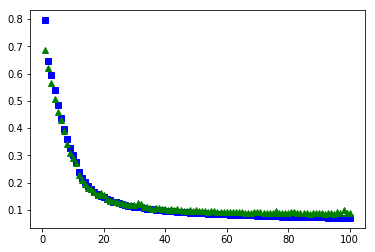

In [21]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

### Cálculo da acurácia no conjunto de testes

In [22]:
test_loss = list()

test_image = list()

test_label_reg = dict()
test_label_class = dict()
test_label_presence = dict()

test_output_reg = dict()
test_output_class = dict()
test_output_presence = dict()

for scale_idx in range(num_scales):
    scale = num_scales - scale_idx

    test_label_reg[scale] = list()
    test_label_class[scale] = list()
    test_label_presence[scale] = list()

    test_output_reg[scale] = list()
    test_output_class[scale] = list()
    test_output_presence[scale] = list()

with torch.no_grad():
    for i, samples in enumerate(dataset_test):
        # get the inputs
        images = samples[0].unsqueeze(0).to(device)

        labels_reg_list = list()
        labels_cls_list = list()
        for scale_idx in range(num_scales):
            labels_reg_list.append(samples[1][scale_idx].unsqueeze(0))
            labels_cls_list.append(samples[2][scale_idx].unsqueeze(0))

        # forward
        output_list = multi_scale_model(images)
        loss = crit(output_list, labels_reg_list, labels_cls_list)

        test_loss.append(loss.cpu().item())

        test_image.append(samples[0].numpy())

        for scale_idx in range(num_scales):
            scale = num_scales - scale_idx
            test_label_reg[scale].append(samples[1][scale_idx].numpy())
            test_output_reg[scale].append(output_list[scale_idx][0, 0:2].cpu().numpy())

            samples_cls_array = samples[2][scale_idx].numpy()
            test_label_class[scale].append(samples_cls_array[0])
            test_output_class[scale].append(np.argmax(output_list[scale_idx][0, 2:12].cpu().numpy(), axis=0))

            test_label_presence[scale].append(samples_cls_array[1])
            test_output_presence[scale].append(np.argmax(output_list[scale_idx][0, 12:].cpu().numpy(), axis=0))

In [23]:
test_loss_array = np.array(test_loss)
test_loss_idx = np.argsort(test_loss_array)

test_arrays = {
    'image_array': np.concatenate(test_image),
    'label_reg_array': dict(),
    'output_reg_array': dict(),
    'label_class_array': dict(),
    'output_class_array': dict(),
    'label_presence_array': dict(),
    'output_presence_array': dict()
}

for scale_idx in range(num_scales):
    scale = num_scales - scale_idx
    test_arrays['label_reg_array'][scale] = np.stack(test_label_reg[scale])
    test_arrays['output_reg_array'][scale] = np.stack(test_output_reg[scale])
    test_arrays['label_class_array'][scale] = np.stack(test_label_class[scale])
    test_arrays['output_class_array'][scale] = np.stack(test_output_class[scale])
    test_arrays['label_presence_array'][scale] = np.stack(test_label_presence[scale])
    test_arrays['output_presence_array'][scale] = np.stack(test_output_presence[scale])

In [24]:
num_digits = 0
correct_digits = 0

for scale_idx in range(num_scales):
    scale = num_scales - scale_idx

    predicted_digits = (test_arrays['output_class_array'][scale] * test_arrays['output_presence_array'][scale])
    num_digits += np.sum(test_arrays['label_presence_array'][scale])
    correct_digits += np.sum(predicted_digits == test_arrays['label_class_array'][scale])

print(f'Acurácia: {correct_digits * 100.0 / num_digits:2.3f}%')

Acurácia: 96.268%


In [25]:
def vizResult(idx, arrays_dict):
    plt.imshow(arrays_dict['image_array'][idx])
    plt.show()

    for scale_idx in range(num_scales):
        scale = num_scales - scale_idx

        print(f'Scale {scale}')
        print(f'    tx label:\n{np.around(arrays_dict["label_reg_array"][scale][idx, 0], decimals=2)}\n')
        print(f'    tx predict:\n{np.around(arrays_dict["output_reg_array"][scale][idx, 0], decimals=2)}\n')
        print('\n')
        print(f'    ty label:\n{np.around(arrays_dict["label_reg_array"][scale][idx, 1], decimals=2)}\n')
        print(f'    ty predict:\n{np.around(arrays_dict["output_reg_array"][scale][idx, 1], decimals=2)}\n')
        print('\n')
        print(f'    class label:\n{arrays_dict["label_class_array"][scale][idx]}\n')
        print(f'    class predict:\n{arrays_dict["output_class_array"][scale][idx]}\n')
        print('\n')
        print(f'    presence label:\n{arrays_dict["label_presence_array"][scale][idx]}\n')
        print(f'    presence predict:\n{arrays_dict["output_presence_array"][scale][idx]}\n')

### Exemplo com menor perda

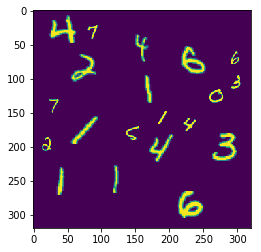

Scale 2
    tx label:
[[ 0.   -0.19  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.94  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.31  0.    0.    0.    0.   -0.5   0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.5   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.38  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.69  0.    0.    0.75  0.  ]
 [ 0.   -0.44  0.    0.62  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.75  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

    tx predict:
[[ 1.23 -0.01 -0.   -0.    0.09 -0.    0.03  0.01 -0.   -0.  ]
 [ 1.03 -0.01 -0.    0.31  0.8  -0.01  0.61 -0.01  0.26 -0.01]
 [ 0.3   1.55 -0.01 -0.    0.55 -0.    1.63 -0.02  0.34 -0.01]
 [ 0.1   0.71 -0.01 -0.    1.27 -0.01  0.19 -0.    0.2  -0.01]
 [ 0.14  0.24 -0.   -0.    0.39 -0.    0.27  0.06 -0.   -0.01]
 [ 0.33  1.13 -

In [26]:
vizResult(test_loss_idx[0], test_arrays)

### Exemplo com maior perda

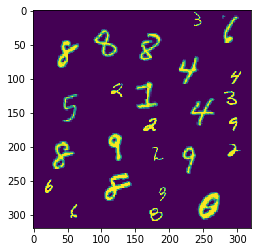

Scale 2
    tx label:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.   -0.31  0.   -0.31  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.81  0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.62  0.    0.    0.    0.  ]
 [ 0.    0.31  0.    0.    0.    0.    0.    0.44  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.44  0.    0.56  0.    0.    0.   -0.62  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.69  0.    0.    0.    0.   -0.81  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

    tx predict:
[[-0.   -0.    0.47 -0.    0.34 -0.    0.59  0.88  0.75 -0.02]
 [ 1.38 -0.01  1.41 -0.01  1.92 -0.02 -0.    0.26  0.79 -0.02]
 [ 1.38 -0.01 -0.   -0.    1.19 -0.01  1.17 -0.01  0.25 -0.01]
 [ 0.22  0.25 -0.    0.27  1.21 -0.01  0.28 -0.    0.43 -0.01]
 [ 0.64  0.41 -0.01  0.27  1.08 -0.01  0.72  0.74 -0.   -0.01]
 [ 0.44 -0.    

In [27]:
vizResult(test_loss_idx[-1], test_arrays)